In [ ]:
%matplotlib notebook
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cufflinks
import plotly.plotly as py
py.sign_in('revilo222', 'qnGBeolE0CtdzjEajfql')

import matplotlib as mpl
mpl.rcParams['font.size'] = 8.5
mpl.rcParams['font.family'] = 'serif'

golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
figWidth = 3.37
mpl.rcParams['figure.figsize'] = figWidth, figWidth * golden_ratio

In [ ]:
df = pd.read_csv('2d_progression.dat', sep='\s+', header=None)

In [ ]:
# from http://stackoverflow.com/questions/17577587/matplotlib-2d-graph-with-interpolation
import scipy.interpolate
import matplotlib.pyplot as plt


def normal_interp(x, y, a, xi, yi):
    rbf = scipy.interpolate.Rbf(x, y, a)
    ai = rbf(xi, yi)
    return ai, rbf

def rescaled_interp(x, y, a, xi, yi):
    a_rescaled = (a - a.min()) / a.ptp()
    ai, interp = normal_interp(x, y, a_rescaled, xi, yi)
    ai = a.ptp() * ai + a.min()
    return ai, rbf

def plot(x, y, a, ai, title):
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)


    im = ax.imshow(ai.T, origin='lower',
                   extent=[x.min(), x.max(), y.min(), y.max()])
    #ax.scatter(x, y, c=a)

    ax.set(xlabel='Mg 2p population', ylabel='O 2p population', title=title)
    fig.colorbar(im)


In [33]:
def bragg_2d_heatmap(df, peak_hkl_string, mode = 'log', norm = True):
    """
    Make a heatmap of the Bragg peak intensity (normalized to 200) as a function of the number of
    2p electrons in Mg and O.
    
    Returns a 2d interpolation function.
    """
    hkl_map = {'111': 2, '200': 3} # map hkls into rows of the data file 2d_progression.dat
    mg_ionization, o_ionization = np.array(df.iloc[:2, :])
    x = mg_ionization[::-1]
    y = o_ionization[::-1]
    progression = np.array(df.iloc[hkl_map[peak_hkl_string], :])
    ref = np.array(df.iloc[hkl_map['200'], :])
    if norm:
        a = progression/ref#/progression.max())
    else:
        a = progression
    xi, yi = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]

    a_orig, interp = normal_interp(x, y, a, xi, yi)
    #a_rescale = rescaled_interp(x, y, a, xi, yi)
    if mode == 'log':
        plot(x, y, np.log(a), np.log(a_orig), ' $\log(I_{%s})$ vs. Mg and O 2p population' % peak_hkl_string)
    elif mode == 'linear':
        plot(x, y, a, a_orig, ' $\I_{%s}/I_{200}$ vs. Mg and O 2p ionization' % peak_hkl_string)
    #plot(x, y, a, a_rescale, 'Rescaled')
    plt.show()
    return interp

Note that we start ionizing the O with only 4 (instead of 6) valence electrons. This corresponds to SCFLY's zero-temperature limit. We can expect it to be inaccurate for temperatures on the order of 1 eV or below.

<IPython.core.display.Javascript object>


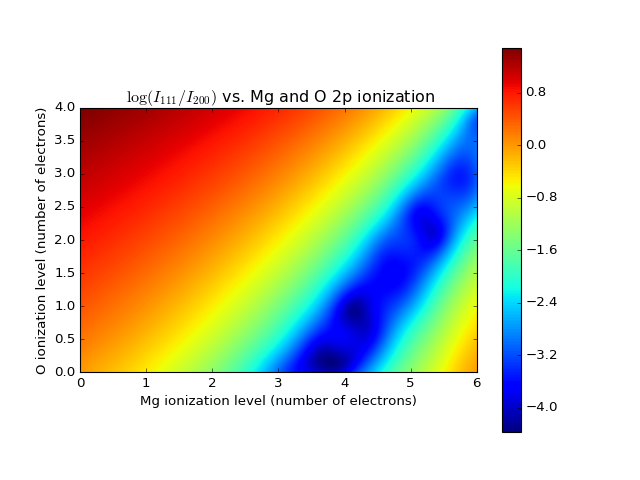

In [16]:
interp2d = bragg_2d_heatmap(df, '111')

<IPython.core.display.Javascript object>


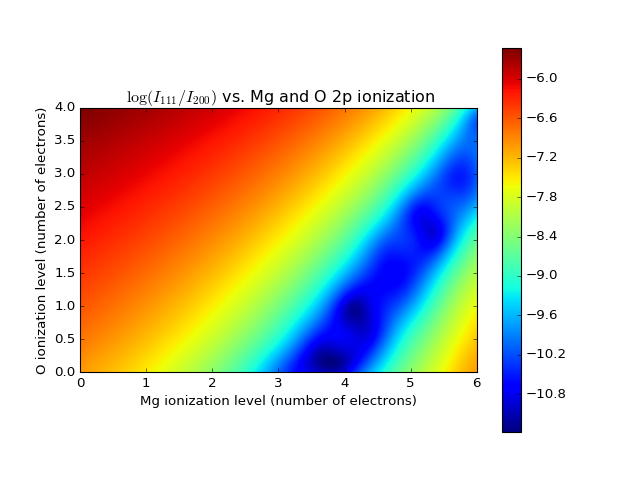

In [44]:
interp2d = bragg_2d_heatmap(df, '111', norm=False)

<IPython.core.display.Javascript object>


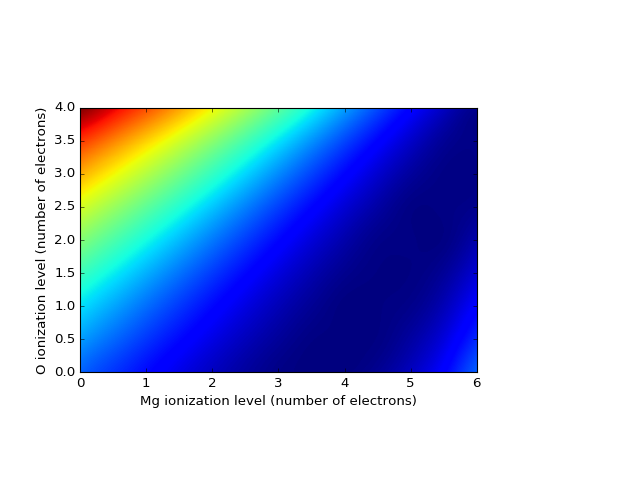

In [45]:
interp2d = bragg_2d_heatmap(df, '111', mode = 'linear')

Same thing with the full domain of ionization levels (instead of just the ones accessible in SCFLY):

<IPython.core.display.Javascript object>


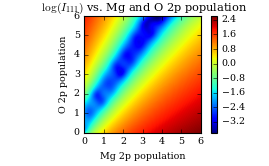

In [34]:
df2 = pd.read_csv('2d_progression_full.dat', sep='\s+', header=None)
bragg_2d_heatmap(df2, '111')

I've 'cleaned up' the file from Sam Vinko to include only the rows of intensity values. 

In [35]:
plt.savefig('2dprogression.png', dpi = 300)

In [6]:
pulse = pd.read_csv('hv_file_intensities', sep = '\s+', header = None)

In [7]:
intensity = pulse.mean(axis = 1)

In [8]:
times = pd.read_csv('hv_file_times', sep = '\s+', header = None)

In [9]:
times.max() # 120 fs

0    1.200000e-13
dtype: float64

In [10]:
populations = pd.read_csv('populations.dat', sep = '\s+') * 2

Extract individual dataframes for the two species, and adjust the mg dataframe so that column index 0 corresponds to Mg2+.

In [11]:
o = populations[pd.Index(['0.1', '1.1', '2.1', '3.1', '4.1', '5.1', '6.1',
       '7.1', '8.1'],
      dtype='object')]
o.columns = pd.Index(['0', '1', '2', '3', '4', '5', '6', '7', '8'],
      dtype='object')

mg = populations[pd.Index(['0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', '11', '12'],
      dtype='object')]
mg = populations[pd.Index(['2', '3', '4', '5', '6', '7', '8',
       '9', '10', '11', '12'],
      dtype='object')]
mg.columns = pd.Index(['0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10'],
      dtype='object')

statevars = populations[pd.Index(['Te', 'Ne'],
      dtype='object')]
statevars/= 2

In [15]:
o.iplot()

In [13]:
def get_charge_states(atom):
    """
    given mg or o, return a 1d of charge states for all time points.
    """
    charge_weights = np.array(atom.columns, dtype = int)
    charge_states = (atom * charge_weights).sum(axis = 1)
    return charge_states

### Temporal progressions of Mg and O charge states:

In [21]:
charge_o = get_charge_states(o).to_frame()
charge_mg = get_charge_states(mg).to_frame()
charge_o.index = times
charge_mg.index = times

oc = get_charge_states(o)
oc[0]=oc[1]
oc = oc - oc[0]

In [35]:
charge_o.iloc[:,0] -= 1.226248e-01

<IPython.core.display.Javascript object>


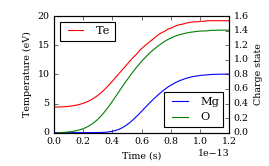

In [125]:
statevars['Te'][0] = statevars['Te'][1]
statevars_time = statevars.set_index(charge_mg.index)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(statevars_time['Te'], color = 'r')
ax1.set_ylim(0, 20)
ax1.set_ylabel('Temperature (eV)')

ax2.plot(charge_mg, label = 'Mg')
ax2.plot(charge_o, label = 'O')
ax2.set_ylim(0, 1.6)
ax2.set_xlim(0, 1.2e-13)
ax1.set_xlabel('Time (s)')
ax2.set_ylabel('Charge state')


ax2.legend(loc='lower right')
ax1.legend(loc = 'upper left')
plt.gcf().subplots_adjust(bottom=0.2, left = 0.2, right = 0.85)
fig.savefig('charge_states.png', dpi = 300, bbox_inches='tight')

<IPython.core.display.Javascript object>


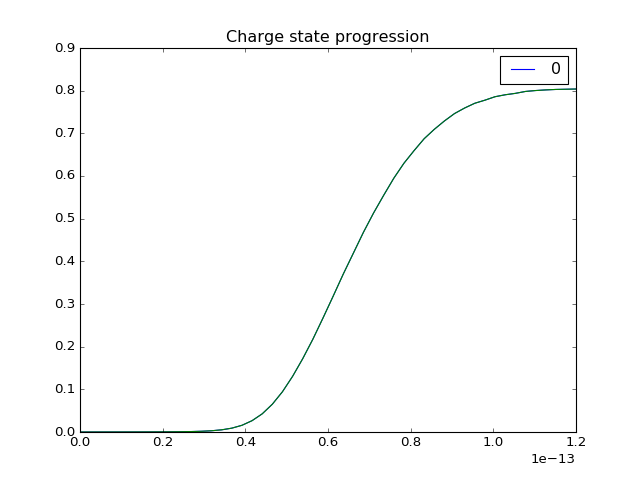

In [15]:
charge_mg.plot(title='Charge state progression')

<IPython.core.display.Javascript object>


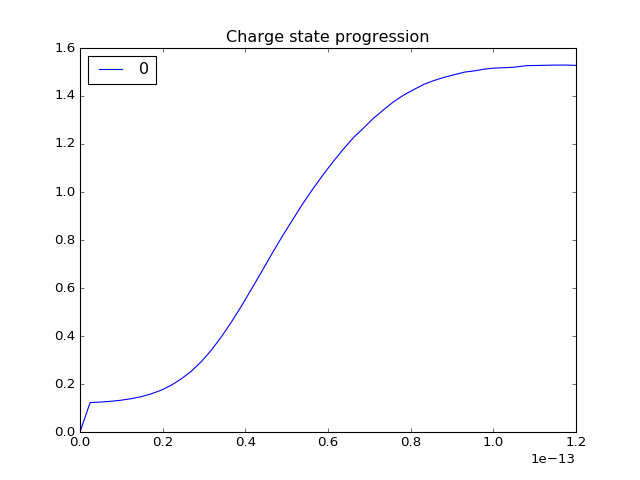

In [63]:
charge_o.plot(title = 'Charge state progression')

### Pulse temporal profile:

<IPython.core.display.Javascript object>


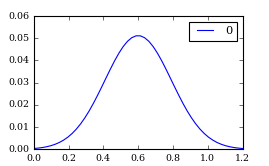

In [68]:
iframe = intensity.to_frame()
iframe.index = times
iframe/= iframe.sum()
iframe.plot()

### Temporal progression of $I_{111}/I_{200}$:

<IPython.core.display.Javascript object>


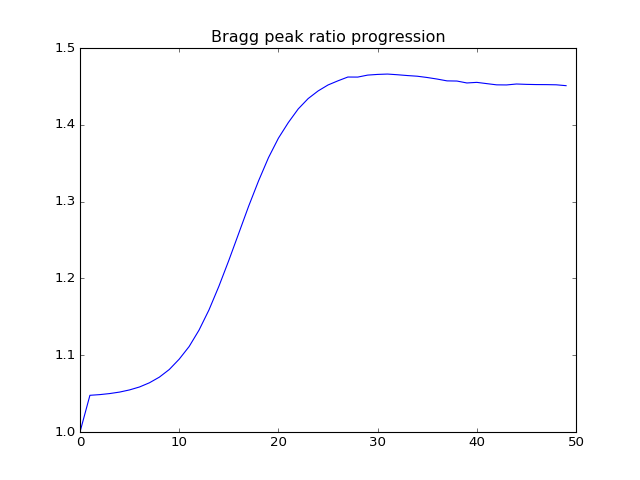

In [66]:
plt.title('Bragg peak ratio progression')
plt.plot(interp2d(charge_mg, charge_o))

### Calculate weighted average of  $I_{111}/I_{200}$ over the pulse duration: 

In [17]:
profile = np.array(iframe).T
np.dot(profile, interp2d(charge_mg, charge_o))

array([[ 1.39137786]])

### Estimate energy of the Mg and O 2p holes:

In [20]:
def dose_vs_2p_energy(path, label = None):
    populations = pd.read_csv(path, sep = '\s+') * 2
    o = populations[pd.Index(['0.1', '1.1', '2.1', '3.1', '4.1', '5.1', '6.1',
       '7.1', '8.1'], dtype='object')]
    o.columns = pd.Index(['0', '1', '2', '3', '4', '5', '6', '7', '8'],
          dtype='object')

    mg = populations[pd.Index(['0', '1', '2', '3', '4', '5', '6', '7', '8',
           '9', '10', '11', '12'],
          dtype='object')]
    mg = populations[pd.Index(['2', '3', '4', '5', '6', '7', '8',
           '9', '10', '11', '12'],
          dtype='object')]
    mg.columns = pd.Index(['0', '1', '2', '3', '4', '5', '6', '7', '8',
           '9', '10'],
          dtype='object')
    
    o_2p_binding = 13.
    mg_2p_binding = 49.5
    oc = get_charge_states(o)
    oc[0]=oc[1]
    oc = oc - oc[0]
    mgc = get_charge_states(mg)
    o_energy = oc * o_2p_binding
    mg_energy = mgc * mg_2p_binding
    energy = o_energy + mg_energy
    dose = iframe[0].cumsum() * 154. # XFEL dose as a function of time in eV
    dose['XFEL dose']= np.array(energy)
    dose.columns = ['2p vacancy energy', 'XFEL dose']

    dose.plot()
    return dose

In [64]:
paths = ['populations/pp.i%s' % i for i in range(1, 11)]

In [65]:
# copied from MgO_VASP.ipynb
intensities_ev = np.array([154.14944071736966,
 101.19221587512455,
 66.431424775821981,
 43.610194619727665,
 28.628498970441711,
 18.793933776154102,
 12.3376623048821,
 8.0991355695782126,
 5.3169499169711054,
 3.4903467286615744])

In [66]:
def dose_vs_2p_energy(path, intensity, label = ''):
    populations = pd.read_csv(path, sep = '\s+') * 2
    o = populations[pd.Index(['0.1', '1.1', '2.1', '3.1', '4.1', '5.1', '6.1',
       '7.1', '8.1'], dtype='object')]
    o.columns = pd.Index(['0', '1', '2', '3', '4', '5', '6', '7', '8'],
          dtype='object')

    mg = populations[pd.Index(['0', '1', '2', '3', '4', '5', '6', '7', '8',
           '9', '10', '11', '12'],
          dtype='object')]
    mg = populations[pd.Index(['2', '3', '4', '5', '6', '7', '8',
           '9', '10', '11', '12'],
          dtype='object')]
    mg.columns = pd.Index(['0', '1', '2', '3', '4', '5', '6', '7', '8',
           '9', '10'],
          dtype='object')

    o_2p_binding = 13.
    mg_2p_binding = 49.5
    oc = get_charge_states(o)
    oc[0]=oc[1]
    oc = oc - oc[0]
    mgc = get_charge_states(mg)
    o_energy = oc * o_2p_binding
    mg_energy = mgc * mg_2p_binding
    energy = o_energy + mg_energy
    dose = iframe[0].cumsum().to_frame() * intensity # XFEL dose as a function of time in eV
    dose['XFEL dose']= np.array(energy)
    dose.columns = ['2p vacancy energy', 'XFEL dose']

    return dose